<a href="https://colab.research.google.com/github/nadavschwalb/image_processing/blob/main/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 - Image Restoration

## Goal: Introduction to image restoration

## ---  Make sure you are using GPU accelerator in Colab Runtime  ---

**Student IDs: 206180507 , 302208251**

Import the necessary libraries

In [74]:
%matplotlib inline 
import numpy as npm
import matplotlib.pyplot as plt
from skimage import transform,io,util,img_as_float
from skimage import restoration
import skimage
import cv2
from math import sqrt

Mount to your drive to open files.

In [7]:
#Mount:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/image_processing/Lab_5'
%ls # (print the files and folders in the crrent folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/image_processing/Lab_5'
/content/drive/MyDrive/image_processing/Lab_5
Lab_5_preliminary.ipynb  lena.gif  printtopdf.ipynb
Lab_5_preliminary.pdf    pony.jpg


Insert your implementaion - add blurring and noise to image:

In [27]:
# The function return two images: a blurred image 
# and an image after blurring and noise adding
def AddBlurreAndNoise(img, filter_blur,sigma=0.01):
  img_blurre = cv2.filter2D(img,-1,filter_blur)
  img_blurre_noise = skimage.util.random_noise(img_blurre,var=sigma)
  return img_blurre, img_blurre_noise
    

Load image:

[[125 127 128 ...  46  46  45]
 [126 127 129 ...  47  47  47]
 [126 127 129 ...  48  47  47]
 ...
 [ 42  30  26 ...  37  26  30]
 [ 46  16   7 ...  28  31  71]
 [ 18  14   6 ...  41  52  84]]
Image shape:(511, 766), Image data type:float64


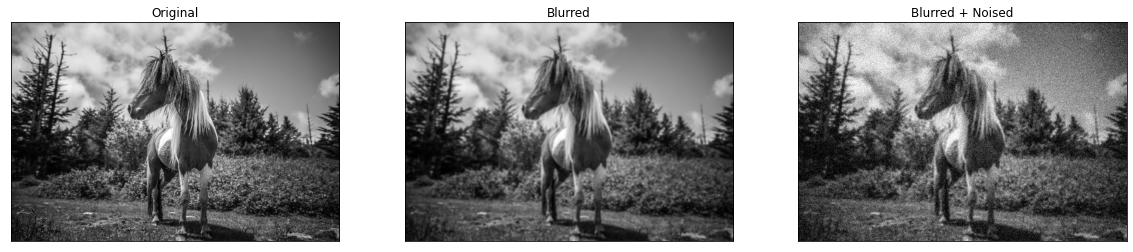

In [70]:
img = io.imread('pony.jpg')
img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img = img_as_float(img)
print ("Image shape:{}, Image data type:{}".format(img.shape,img.dtype))
# Use gaussian kernel for burring the image
# gaussian kernel is separable function
filter_blur = cv2.getGaussianKernel(ksize=5,sigma=1.85)*cv2.getGaussianKernel(ksize=5,sigma=1.85).T 
blurred, noise = AddBlurreAndNoise(img,filter_blur)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(blurred, cmap='gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.show()

###  Part 1 - Inverse Filter

1. Test the restoration with the Inverse Filter for deblurring and denoising

In [29]:
def InverseFilter(noise_img,filter_blur):
  degraded_dft = np.fft.fftshift(np.fft.fft2(noise_img))
  blur_dft = np.fft.fftshift(np.fft.fft2(filter_blur,(noise_img.shape[0],noise_img.shape[1])))
  restored_dft = degraded_dft/blur_dft
  return np.abs(np.fft.ifft2(restored_dft))


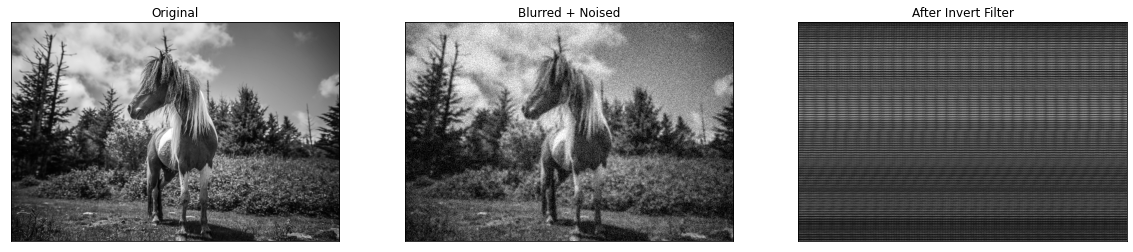

In [11]:
denoise_Invert_img = InverseFilter(noise,filter_blur)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_Invert_img, cmap='gray'),plt.title('After Invert Filter')
plt.xticks([]), plt.yticks([])
plt.show()

2. What is the problem with the Inverse Filter? How can this be solved?

```
# Insert your answer here
```

### Part 2 - Pseudo Inverse Filter

1. Test the restoration with the Pseudo Inverse Filter for deblurring and denoising.

In [30]:
def PseudoInverseFilter(noise_img,filter_blur,epsilon=0.5):
    degraded_dft = np.fft.fftshift(np.fft.fft2(noise_img))
    blur_dft = np.fft.fftshift(np.fft.fft2(filter_blur,(noise_img.shape[0],noise_img.shape[1])))
    vectorize_threshold = np.vectorize(lambda x : 1/x if x > epsilon else 0)
    psuedo_inverse_filter = vectorize_threshold(np.abs(blur_dft))
    restored_dft = degraded_dft*psuedo_inverse_filter
    return np.abs(np.fft.ifft2(restored_dft))


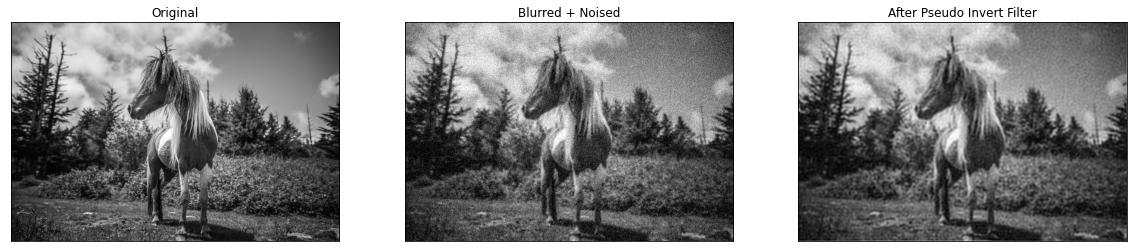

In [31]:
denoise_pseudo_img = PseudoInverseFilter(noise,filter_blur,epsilon=0.55)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_pseudo_img, cmap='gray'),plt.title('After Pseudo Invert Filter')
plt.xticks([]), plt.yticks([])
plt.show()

The Root Mean Square (RMS) error of restoration is defined in the following way:
\begin{equation*}
RMS = \left( \frac{1}{MN}  \sum_{k=0}^{M-1} \sum_{k=0}^{N-1} (\hat{f}(i,j)-f(i,j))^2 \right)^{0.5}
\end{equation*}

where $f(i, j)$ is the original image, $\hat{f}(i,j)$ is the restored image and $M \times N$ is the size of both images. 


2. Plot the graph of the RMS error (Y axis) versus the parameter $\epsilon$(X axis) . Use several values in the range 0-1

(the variance of the noise $\sigma _n ^2$ is fixed to the default value in the supplied program).


In [75]:
def restoration_rms(original, restored):
  rms = 0
  for i,row in enumerate(original):
    for j, pixel in enumerate(row):
      rms += pow((restored[i,j] - pixel),2)
  M = original.shape[0]
  N = original.shape[1]
  rms = sqrt((1/(M*N))*rms)
  return rms


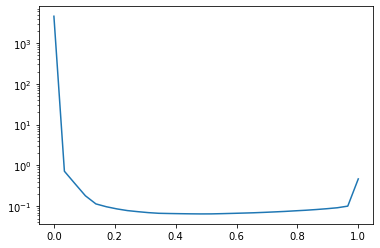

In [52]:
epsilons = np.linspace(0,1,num=30)
restored_epsilon = [PseudoInverseFilter(noise,filter_blur,epsilon=x) for x in epsilons]
rms = [restoration_rms(img,x) for x in restored_epsilon]
plt.yscale("log")
plt.plot(epsilons,rms)

__Show the result of the best restoration by the best epsilon value.__ (if it different than the previous shown result)


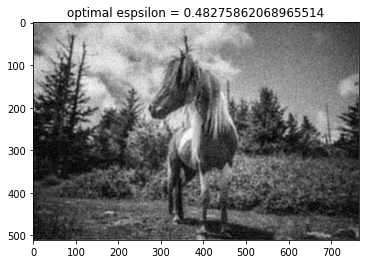

In [53]:
optimal_epsilon = epsilons[np.argmin(rms)]
plt.imshow(restored_epsilon[np.argmin(rms)],cmap='gray')
plt.title(f"optimal espsilon = {optimal_epsilon}")
plt.show()

3.Now fix the parameter $\epsilon = 0.5$.
Plot the graph of the Root Mean Square (RMS) error of restoration (Y axis) versus the
variance of the noise $\sigma_n^2$ (X axis).
__And Show the result of the best restoration__
(Use several values in the range 0-1)

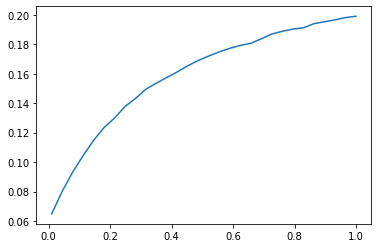

In [62]:
variances = np.linspace(0.01,1,num=30)
restored_sigma = [PseudoInverseFilter(AddBlurreAndNoise(img,filter_blur,x)[1],filter_blur, epsilon=0.5) for x in variances]
rms = [restoration_rms(img,x) for x in restored_sigma]
#plt.yscale("log")
plt.plot(variances,rms)

   3.1. For what maximal value of the variance of the noise you still get an acceptable restoration? **show the noisy and result plots**

```
# Insert your answer here
```

### Part 3 - Wiener Filter

1. Test the restoration with the Wiener Filter for deblurring and denoising

Assume that the variance used in the Wiener filter formula is equal to the variance of the noise $\sigma_n^2$
, and both of them are equal to 0.01 (for image in a range of 0-1) or 0.01 ∗ 255
(for image in a range of 0-255).

In [78]:
def WienerFilter(noise_img,filter_blur,sigma=0.01, alpha=0.095):
    degraded_dft = np.fft.fftshift(np.fft.fft2(noise_img))
    blur_dft = np.fft.fftshift(np.fft.fft2(filter_blur,(noise_img.shape[0],noise_img.shape[1])))
    conjugate_blur_dft = np.conjugate(blur_dft)
    abs_square_blur = np.square(np.abs(blur_dft))
    weiner_dft = np.zeros(blur_dft.shape)
    for i,row in enumerate(weiner_dft):
      for j,cell in enumerate(row):
        weiner_dft[i,j] = conjugate_blur_dft[i,j]/(abs_square_blur[i,j]+ alpha*np.square(sigma)*(i**2 + j**2))
    restored_dft = degraded_dft*weiner_dft
    return np.abs(np.fft.ifft2(restored_dft))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


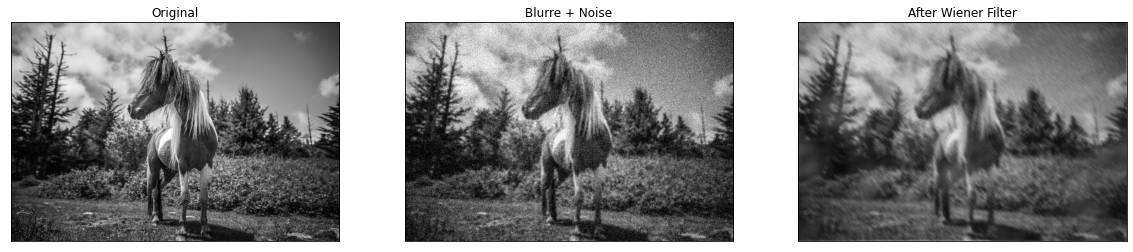

In [79]:
denoise_wiener_img = WienerFilter(noise,filter_blur)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurre + Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_wiener_img, cmap='gray'),plt.title('After Wiener Filter')
plt.xticks([]), plt.yticks([])
plt.show()

2. Plot the graph of the Root Mean Square (RMS) error of restoration (Y axis) versus the parameter $\sigma_n^2$ (X axis) (change $\sigma_n$ only in the filter, the noise image stay the same, also no need to change alpha). __Show the result of the best restoration.__

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


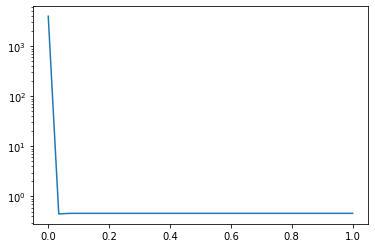

In [80]:
sigma = np.linspace(0,1,30)
weiner_restored = [WienerFilter(noise,filter_blur,sigma=x) for x in sigma]
rms_wiener = [restoration_rms(img,x) for x in weiner_restored]
plt.yscale("log")
plt.plot(sigma,rms_wiener)

### Part 4 - Deep learning (DnCNN)

1. After using a few filters to restoration the image, Lets try with the new approach **Deep learning** and compare the results

For building the neural network we will use the [PyTorch framwork](https://pytorch.org/) 

Because of lack of time we aren't going to train the network here.
We will use a pretrained model

Few more imports for using pytorch:

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

Now we will define the architecture of the neural network.

We will implement the [DnCNN](http://www4.comp.polyu.edu.hk/~cslzhang/paper/DnCNN.pdf) architecture:

![DnCNN architecture](https://raw.github.com/cszn/DnCNN/master/figs/dncnn.png)

Has you can see the architecture is a class that inherit from nn.Module (pytorch module) 

In [ ]:
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        # first layer: conv2d -> Relu (for activation) :
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        # then lets defined all the other hidden layer as: conv2d -> BatchNorm -> Relu
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        # and at the end: need to get back the image so conv2d with out_channels as in the original image:
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        # insert all the layers in to Sequential that will pass the data in order
        self.dncnn = nn.Sequential(*layers)
        
    def forward(self, x):
        # defined the forward pass of our network
        out = self.dncnn(x)
        return out


lets pay attention that we don't need to defined the back propagation as the the Pytorch framework will do it for us.

2. What is the *Conv* in the network architecture? Give a brief explanation (up to 4 lines)



```
# Insert your answer here
```



After build the network architecture we need to load the pretrained model and insert the noisy image to it:

In [ ]:
def DnCNN_network(noise_img, num_of_layers=17, model_path='net.pth'):
    
    print('Loading model ...')
    # defined the network, use the class we create above
    net = DnCNN(channels=1, num_of_layers=num_of_layers)
    traind_model = nn.DataParallel(net)
    # load pretrain model
    pretraind = torch.load(model_path)
    # get the state of the model (weights + baises ...)
    traind_model.load_state_dict(pretraind)
    traind_model.double()
    # say to pytorch that we juist want to test the model (not tarin it)
    traind_model.eval()
    print('Loaded\n')
    # Expend dim for using the network:
    noise_img = np.expand_dims(noise_img, 0) # batch dim
    noise_img = np.expand_dims(noise_img, 1) # channels dim
    # cast to tensor variable 
    noise_img = torch.DoubleTensor(noise_img)
    INoisy = Variable(noise_img)
    
    with torch.no_grad(): # this can save much memory
        print("Inserting the noisy image...\n")
        the_noise_that_we_learned = traind_model(INoisy)
        plt.imshow(the_noise_that_we_learned.cpu().squeeze(), cmap='gray'),plt.title('The noise that the network predict')
        plt.show()
        Out = torch.clamp(INoisy.cpu() - the_noise_that_we_learned.cpu(), 0., 1.)
    return Out.squeeze()



3. Explain the following line in the code. Why do we need this line? 

*Out = torch.clamp(INoisy.cpu() - the_noise_that_we_learned.cpu(), 0., 1.)*


```
# Insert your answer here
```

Now lets use the neural network and show the results:

In [ ]:
denoise_dncnn_img = DnCNN_network(noise)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurre + Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_dncnn_img, cmap='gray'),plt.title('After substract the noise that learned')
plt.xticks([]), plt.yticks([])
plt.show()

Loading model ...


FileNotFoundError: ignored

4. Lets compare the results from all the methods that we used in this lab:

   Show the best image after restoration from all the methods (Pseudo Invert Filter, Wiener Filter, DnCNN)

In [ ]:
# Insert your code here
